In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import normalize
from tensorflow import keras

In [2]:
data = pd.read_excel('marked_data.xlsx')

In [3]:
data

,Signal,isActive,TimeStamp
0,118,0,0
1,117,0,1
2,122,0,2
3,123,0,3
4,119,0,4
...,...,...,...
33597,130,0,33597
33598,119,0,33598
33599,104,0,33599
33600,115,0,33600


In [4]:
data = data[0 : 33600]

In [5]:
data

,Signal,isActive,TimeStamp
0,118,0,0
1,117,0,1
2,122,0,2
3,123,0,3
4,119,0,4
...,...,...,...
33595,105,0,33595
33596,116,0,33596
33597,130,0,33597
33598,119,0,33598


In [6]:
#splitting data on same-size windows
window_size = 200
overlapping_size = 160

In [80]:
windowed = np.empty([(data.shape[0] - window_size) // (window_size - overlapping_size) + 1, 1, window_size, 2])
windowed.shape

(836, 1, 200, 2)

In [81]:
window_num = 0
for i in range(0, data.shape[0]-window_size + 1, window_size-overlapping_size):
  windowed[window_num] = data[['Signal', 'isActive']][i : i + window_size].to_numpy()[None, ...]
  #print(windowed[window_num].shape)
  window_num += 1

In [82]:
windowed.shape

(836, 1, 200, 2)

In [83]:
X_train = windowed[:, :, :, 0]
Y_train = np.array([1 if np.mean(windowed[i, :, :, 1]) > 0.5 else 0 for i in range(0, windowed.shape[0])])

In [84]:
X_train.shape

(836, 1, 200)

In [85]:
Y_train.shape

(836,)

In [45]:
def color_via_value(value):
  if value == 0:
    return 'blue'
  elif value == 1:
    return 'red'

ValueError: ignored

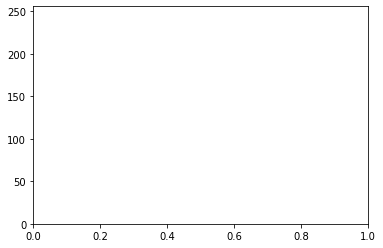

In [46]:
for i in range(100, 120):
  window = windowed[i]
  plt.ylim([0, 256])
  plt.scatter(range(i, i+window_size), window[:, 0], c=list(map(color_via_value, window[:, 1])))
  plt.show()
  print(Y_train[i])

In [87]:
X_train = X_train[..., None]
Y_train = Y_train[..., None]

In [88]:
X_train.shape

(836, 1, 200, 1)

In [89]:
Y_train.shape

(836, 1)

Architecture taked from [here](https://github.com/atomic14/diy-alexa/blob/master/model/Train%20Model.ipynb) and changed for 1d conv

In [100]:
def make_model(input_shape):
  model = keras.Sequential([
      keras.layers.Conv2D(4, (1, 3), 
            padding='same',
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(0.001),
            name='conv_layer1',
            input_shape=(input_shape)),
      keras.layers.MaxPooling2D(name='max_pooling1', pool_size=(1, 2)),
      keras.layers.Conv2D(4, (1, 3), 
            padding='same',
            activation='relu',
            kernel_regularizer=keras.regularizers.l2(0.001),
            name='conv_layer2'),
      keras.layers.MaxPooling2D(name='max_pooling2', pool_size=(1,2)),
      keras.layers.Flatten(),
      keras.layers.Dropout(0.2),
      keras.layers.Dense(
          40,
          activation='relu',
          kernel_regularizer=keras.regularizers.l2(0.001),
          name='hidden_layer1'
      ),
      keras.layers.Dense(
          1, 
          activation='sigmoid',
          kernel_regularizer=keras.regularizers.l2(0.001),
          name='output'
      )
  ])

  return model
 

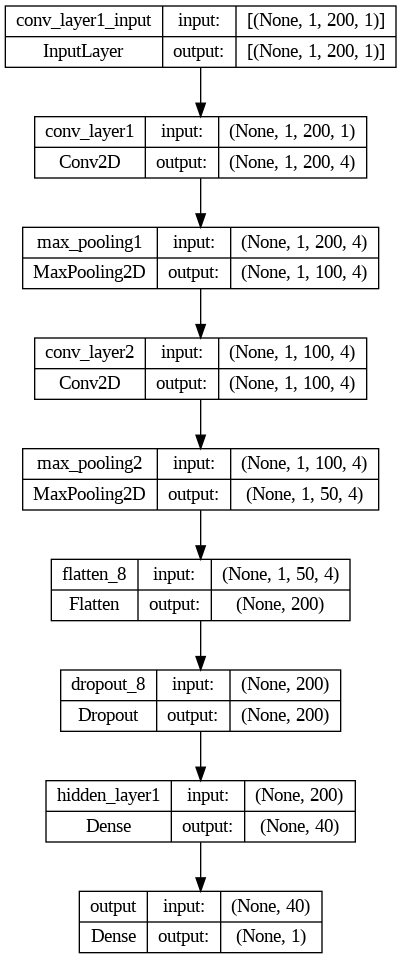

In [101]:
model = make_model(input_shape=X_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [102]:
model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_layer1 (Conv2D)        (None, 1, 200, 4)         16        
                                                                 
 max_pooling1 (MaxPooling2D)  (None, 1, 100, 4)        0         
                                                                 
 conv_layer2 (Conv2D)        (None, 1, 100, 4)         52        
                                                                 
 max_pooling2 (MaxPooling2D)  (None, 1, 50, 4)         0         
                                                                 
 flatten_8 (Flatten)         (None, 200)               0         
                                                                 
 dropout_8 (Dropout)         (None, 200)               0         
                                                                 
 hidden_layer1 (Dense)       (None, 40)               

In [103]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]

model.compile(optimizer='adam',
              loss=keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

history = model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
21/21 [==============================] - 2s 21ms/step - loss: 0.7323 - accuracy: 0.7754 - val_loss: 1.0179 - val_accuracy: 0.8869 - lr: 0.0010
Epoch 2/500
21/21 [==============================] - 0s 11ms/step - loss: 0.4573 - accuracy: 0.8443 - val_loss: 1.3716 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 3/500
21/21 [==============================] - 0s 9ms/step - loss: 0.4204 - accuracy: 0.8683 - val_loss: 1.3253 - val_accuracy: 0.8988 - lr: 0.0010
Epoch 4/500
21/21 [==============================] - 0s 8ms/step - loss: 0.3662 - accuracy: 0.8787 - val_loss: 1.4495 - val_accuracy: 0.8810 - lr: 0.0010
Epoch 5/500
21/21 [==============================] - 0s 8ms/step - loss: 0.3552 - accuracy: 0.8967 - val_loss: 1.5965 - val_accuracy: 0.8333 - lr: 0.0010
Epoch 6/500
21/21 [==============================] - 0s 8ms/step - loss: 0.3498 - accuracy: 0.8802 - val_loss: 1.3330 - val_accuracy: 0.8750 - lr: 0.0010
Epoch 7/500
21/21 [==============================] - 0s 8ms/step - loss: 0

In [104]:
Y_train.shape

(836, 1)

Window num:
0


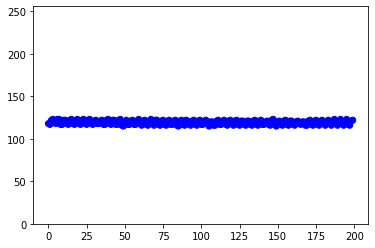

real label:
[0]
predicted label:
1/1 [==============================] - 0s 99ms/step
[[0.0169272]]

Window num:
10


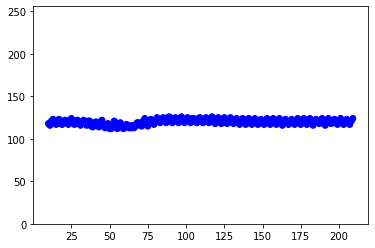

real label:
[0]
predicted label:
1/1 [==============================] - 0s 44ms/step
[[0.01592215]]

Window num:
20


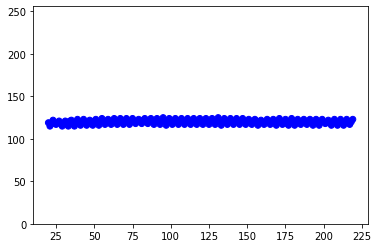

real label:
[0]
predicted label:
1/1 [==============================] - 0s 44ms/step
[[0.01537018]]

Window num:
30


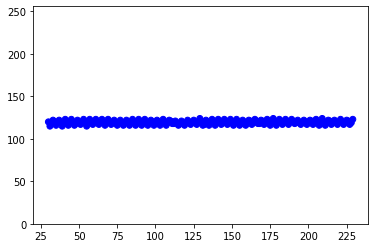

real label:
[0]
predicted label:
1/1 [==============================] - 0s 40ms/step
[[0.01452664]]

Window num:
40


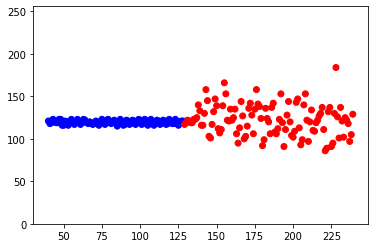

real label:
[1]
predicted label:
1/1 [==============================] - 0s 41ms/step
[[0.99738073]]

Window num:
50


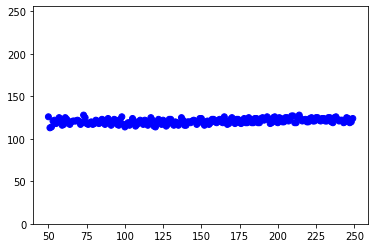

real label:
[0]
predicted label:
1/1 [==============================] - 0s 42ms/step
[[0.01176552]]

Window num:
60


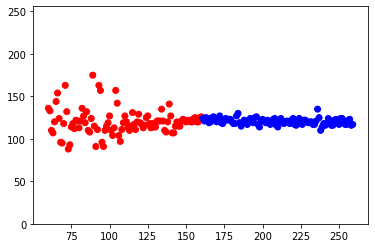

real label:
[1]
predicted label:
1/1 [==============================] - 0s 43ms/step
[[0.8615231]]

Window num:
70


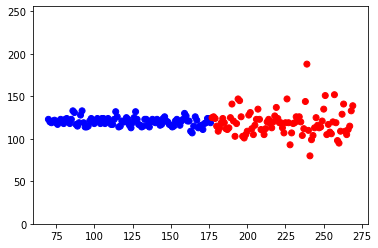

real label:
[0]
predicted label:
1/1 [==============================] - 0s 41ms/step
[[0.540236]]

Window num:
80


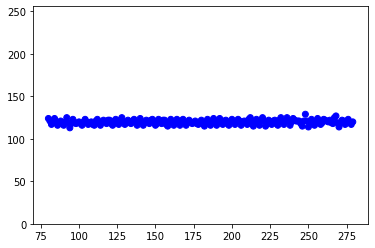

real label:
[0]
predicted label:
1/1 [==============================] - 0s 41ms/step
[[0.01371892]]

Window num:
90


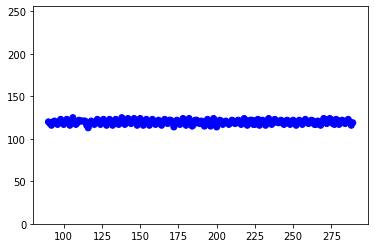

real label:
[0]
predicted label:
1/1 [==============================] - 0s 42ms/step
[[0.01537521]]



In [105]:
for i in range(0, 100, 10):
  print('Window num:' )
  print(i)
  window = windowed[i][0]
  plt.ylim([0, 256])
  plt.scatter(range(i, i+window_size), window[:, 0], c=list(map(color_via_value, window[:, 1])))
  plt.show()
  print("real label:")
  print(Y_train[i])
  print("predicted label:")
  print(model.predict([X_train[i].tolist()]))
  print()

In [106]:
from tensorflow import lite
keras_model = keras.models.load_model("/content/best_model.h5")
converter = lite.TFLiteConverter.from_keras_model(keras_model)
tfmodel = converter.convert()
open ("model.tflite" , "wb").write(tfmodel)

36140